# Skript: Hochschulschriften FB Germanistik (Literaturwissenschaft) auswerten

**Links:**

DNB-Datensatz:

https://www.dnb.de/DE/Professionell/DDC-Deutsch/DDCUebersichten/ddcUebersichten_node.html

https://www.dnb.de/DE/Professionell/Metadatendienste/Exportformate/MARC21/marc21_node.html

https://data.dnb.de/OnlineDissertationsFree/

https://www.dnb.de/DE/Professionell/Services/WissenschaftundForschung/DNBLab/dnblabFreieDigitaleObjektsammlung.html

catalog=dnb.hss and location=onlinefree and ddc=83*

   

Python:

https://www.stechies.com/download-file-python/

https://pypdf.readthedocs.io/en/latest/ (Es wurde mit PyPDF2 gearbeitet, da das wohl etwas schneller funktioniert. Die Codes sind identisch.)

https://stackoverflow.com/questions/42069887/read-all-pdfs-in-a-directory-image

https://stackoverflow.com/questions/34837707/how-to-extract-text-from-a-pdf-file

https://www.delftstack.com/de/howto/python/python-remove-punctuation-from-list/

https://github.com/solariz/german_stopwords/blob/master/german_stopwords_full.txt

https://www.geeksforgeeks.org/generating-word-cloud-python/

https://amueller.github.io/word_cloud/generated/wordcloud.WordCloud.html

## Vorbereitung: SRU-Abfrage

Hier wird vor allem mit einer angepassten Version des SRU-Tutorials des DNB-Labs gearbeitet.

In [25]:
# Die nötigen Pakete importieren

import requests
from bs4 import BeautifulSoup as soup
import unicodedata
from lxml import etree
import pandas as pd

In [29]:
# Funktion für die SRU-Abfrage

def dnb_sru(query):
    
    base_url = "https://services.dnb.de/sru/dnb"
    params = {'recordSchema' : 'MARC21-xml',
          'operation': 'searchRetrieve',
          'version': '1.1',
          'maximumRecords': '100',
          'query': query
         }
    r = requests.get(base_url, params=params)
    xml = soup(r.content)
    records = xml.find_all('record', {'type':'Bibliographic'})
    
    if len(records) < 100:
        
        return records
    
    else:
        
        num_results = 100
        i = 101
        while num_results == 100:
            
            params.update({'startRecord': i})
            r = requests.get(base_url, params=params)
            xml = soup(r.content)
            new_records = xml.find_all('record', {'type':'Bibliographic'})
            records+=new_records
            i+=100
            num_results = len(new_records)
            
        return records

In [34]:
#Definition, welche Einträge gezogen werden sollen

def parse_record(record):
    
    ns = {"marc":"http://www.loc.gov/MARC21/slim"}
    xml = etree.fromstring(unicodedata.normalize("NFC", str(record)))
    
    #idn
    idn = xml.xpath("marc:controlfield[@tag = '001']", namespaces=ns)
    try:
        idn = idn[0].text
    except:
        idn = 'fail'
    
    # titel
    titel = xml.xpath("marc:datafield[@tag = '245']/marc:subfield[@code = 'a']", namespaces=ns)
    
    try:
        titel = titel[0].text
        #titel = unicodedata.normalize("NFC", titel)
    except:
        titel = "unknown"
        
    # links (insgesamt werden, wenn möglich, vier Links gezogen, von denen einer direkt zum Volltext führen sollte)
    link = xml.xpath("marc:datafield[@tag = '856']/marc:subfield[@code = 'u']", namespaces=ns)
    
    try:
        link = link[0].text # Link 1
        
    except:
        link = "unknown"
        
    link2 = xml.xpath("marc:datafield[@tag = '856']/marc:subfield[@code = 'u']", namespaces=ns)   
    
    try:
        link2 = link2[1].text # Link 2
        
    except:
        link2 = "unknown"
        
    link3 = xml.xpath("marc:datafield[@tag = '856']/marc:subfield[@code = 'u']", namespaces=ns)
    
    try:
        link3 = link3[2].text # Link 3
        
    except:
        link3 = "unknown"
        
    link4 = xml.xpath("marc:datafield[@tag = '856']/marc:subfield[@code = 'u']", namespaces=ns)
    
    try:
        link4 = link4[3].text # Link 4
        
    except:
        link4 = "unknown"
        
    meta_dict = {"idn":idn,
                 "titel":titel,
                "link":link,
                "link2":link2,
                "link3":link3,
                "link4":link4}
    
    return meta_dict

In [35]:
records = dnb_sru('catalog=dnb.hss and location=onlinefree and ddc=83*') # Alle Einträge der Literaturwissenschaften
print(len(records), 'Ergebnisse')

C:\ProgramData\Anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


294 Ergebnisse


In [36]:
#Schreiben der Ergebnisse aus der Abfrage in ein Dataframe

output = [parse_record(record) for record in records]
df = pd.DataFrame(output)

df.to_csv("SRU_Titel.csv")

In [17]:
# Dataframe nur mit den Links: War für die weitere Bearbeitung nicht nötig

#link_df = df.drop(['idn', 'titel'], axis=1)

In [19]:
# Überprüfen welche anderen Ergebnisse im ersten Link vorhanden sind außer URN und DOI
# Ausgabe, welche weiteren Links bei diesen in der Abfrage gefunden wurden

"""
for zeile in df.index:
    if "https://nbn-resolving.org" not in df["link"][zeile] and "https://doi.org/" not in df["link"][zeile]:
        print(df["link"][zeile], df["link2"][zeile], df["link3"][zeile])
"""

https://hdl.handle.net/20.500.11811/9693 https://nbn-resolving.org/urn:nbn:de:101:1-2022032401560040728501 https://d-nb.info/1253993351/34
https://hdl.handle.net/20.500.11811/8969 https://nbn-resolving.org/urn:nbn:de:101:1-2021031101553343989496 https://d-nb.info/1229086404/34
https://hdl.handle.net/2003/2959 https://nbn-resolving.org/urn:nbn:de:101:1-201103291053 https://d-nb.info/965345254/34


In [66]:
# Erstellen eines Dataframes nur mit URNs als erstem Link
# War für die weitere Bearbeitung doch nicht nötig

"""
df_urn = pd.DataFrame(output)
not_urn_list=[]

for link in df_urn["link"]:
        if "https://nbn-resolving.org" not in link:
            not_urn_list.append(link) 

for link in not_urn_list:
    indexName = df_urn[df_urn["link"] == link].index
    df_urn.drop(indexName, inplace=True)

df_urn.reset_index(drop=True, inplace=True)

df_urn
"""

,idn,titel,link
0,1257255894,Üble Dinge,https://nbn-resolving.org/urn:nbn:de:101:1-202...
1,1225865794,Empfindungsk(r)ampf - Johann Martin Millers em...,https://nbn-resolving.org/urn:nbn:de:bsz:291-u...
2,1250006252,Generationsbücher,https://nbn-resolving.org/urn:nbn:de:hbz:467-2...
3,1257109464,Migrationsliteratur aus der Schweiz,https://nbn-resolving.org/urn:nbn:de:101:1-202...
4,1241401152,(Un-)Bestimmte Zeichen,https://nbn-resolving.org/urn:nbn:de:101:1-202...
...,...,...,...
262,962132152,"""Sprachdeuteleyen""",https://nbn-resolving.org/urn:nbn:de:bsz:352-o...
263,970033419,Undichte Dichtungen,https://nbn-resolving.org/urn:nbn:de:hbz:38-10351
264,962695874,Die Krise der Allegorie in Heinrich Wittenwi...,https://nbn-resolving.org/urn:nbn:de:kobv:83-o...
265,962003573,"Friederike Liman, Briefwechsel mit Rahel Levin...",https://nbn-resolving.org/urn:nbn:de:gbv:18-3950


## Vorbereitung: Download der PDF-Dateien

In [ ]:
# Die nötigen Pakete für den Datei-Download installieren

#pip install wget

In [ ]:
# Die nötigen Module importieren

import wget
import pandas as pd

In [41]:
# Durchgehen jeder einzelnen Zeile im Dataframe und Versuch, den DNB-Link zu downloaden, 
# falls dieser in einem der vier Link-Feldern vorhanden ist
# Ausgabe von Fehlern, falls der Download nicht möglich war oder kein DNB-Link vorhanden war

for zeile in df.index:
    if "https://d-nb.info/" in df["link2"][zeile]:
        try:
            wget.download(df["link2"][zeile])
        except:
            print("\n", df["idn"][zeile], "konnte nicht heruntergeladen werden")
    elif "https://d-nb.info/" in df["link3"][zeile]:
        try:
            wget.download(df["link3"][zeile])
        except:
            print("\n", df["idn"][zeile], "konnte nicht heruntergeladen werden")
    elif "https://d-nb.info/" in df["link4"][zeile]:
        try:
            wget.download(df["link4"][zeile])
        except:
            print("\n", df["idn"][zeile], "konnte nicht heruntergeladen werden")
    else:
        print("\n", df["idn"][zeile], "hat keinen Link zum Herunterladen")

100% [..........................................................................] 1493765 / 1493765
 1208074164 hat keinen Link zum Herunterladen
100% [..........................................................................] 1701186 / 1701186
 1208080504 hat keinen Link zum Herunterladen
100% [..........................................................................] 1464969 / 1464969
 983671451 konnte nicht heruntergeladen werden
100% [..........................................................................] 1780348 / 1780348
 983302782 konnte nicht heruntergeladen werden
100% [..........................................................................] 1774938 / 1774938
 1206192755 hat keinen Link zum Herunterladen
100% [..........................................................................] 1190641 / 1190641
 983271836 konnte nicht heruntergeladen werden
100% [........................................................................] 13401837 / 13401837

### Ergebnisse des Downloads:

288 Dateien wurden heruntergeladen. 6 Dateien hatten entweder keinen Link oder konnten nicht aufgerufen werden. Die drei Einträge ohne Link waren allerdings alle doppelt gelistet und wurden über eine andere IDN und die jeweiligen Links heruntergeladen. 

Bei den Dokumenten 983671451, 983302782 und 983271836 war der Zugriff über die DNB beschränkt. 2 davon (983302782 und 983271836) konnten über einen anderen Link heruntergeladen werden (Goethe_redivivus.pdf und Wiedererkennen Zeitbild und filmische Memoria.pdf).

1 Dokument wude als epub heruntergeladen und kann daher in den weiteren Schritte nicht ausgewertet werden. 

15 Dokumente wurden außerdem als ZIP-Archiv heruntergeladen, das noch entpackt werden musste. Dabei wurden alle enthaltenen PDF-Dateien entpackt.

## 2. Schritt: Einlesen der PDF-Dateien und Speichern als txt.-Datei

In [ ]:
# Den PDF-Reader installieren

#pip install pypdf2

In [2]:
# Importieren der nötigen Module

import os
import glob
from PyPDF2 import PdfReader

In [3]:
#Test-Datei einlesen

reader = PdfReader("Goethe_redivivus.pdf")
number_of_pages = len(reader.pages)
page = reader.pages[10]
text = page.extract_text()
text

' 8 \nEnzensberger 32 ). Bei diesen Texten reizt vor allem der surrealist ische Überraschungseffekt, \nden ein wiedergeborener Goethe auslöst, wenn er sic h mit den Irrungen und Wirrungen \nunserer Gegenwart auseinanderzusetzen hat. Das Erge bnis ist nicht selten eine satirische oder \ngroteske Erzählung, die einerseits zum Lachen anreg t, andererseits aber auch zum \nNachdenken bewegt und ständig auf dem schmalen und bittersüßen Grat zwischen Komik und \nTragik wandelt.  \n \n \n1.2 Über Wahrheit und Spekulation \n \nMan kann Texte dieser bislang nur dürftig untersuch ten Kategorie als Spielart der Gattung \nBiographie betrachten, als weitere Variante einer T extsorte, die im Laufe ihrer Existenz \nbereits öfter eine neue Gestalt angenommen hat. Es ist eine Fortführung und Zuspitzung einer \nArt Lebensbeschreibung, wie sie zum Beispiel Stefan  Zweig bei vielerlei historischen \nGestalten vollzogen hat. Bereits dort unterlag das geschichtliche Datenmaterial der \nEinfühlung des Autors 

In [4]:
# Testdatei: Gesamten Text in eine Variable packen

reader = PdfReader("Goethe_redivivus.pdf")
text = ""
for page in reader.pages:
    text += page.extract_text() + "\n"

Ergebnis: Die Absätze sollten im ganzen Text entfernt werden \n, zum Teil sind Leerzeichen enthalten, wo sie nicht hingehören (mitten im Wort usw.). Ansonsten sind die Ergebnisse gut. Beim Einlesen aller heruntergeladenen PDF-Dateien zeigt sich, dass eine der PDF-Dateien nicht korrekt eingelesen wurde (es werden seltsame Zeichen ausgegeben). Bei der weiteren Auswertung fällt das allerdings nicht ins Gewicht.

In [6]:
# Eine Funktion, um die Namen aller PDF-Dateien in einem Ordner in einer Liste zu speichern
# Quelle (Stackoverflow): s.o. unter Links 

def readfiles():
    os.chdir(r"C:\Users\seibelr")
    pdfs = []
    for file in glob.glob("*.pdf"):
        pdfs.append(file)
    return pdfs 

In [7]:
pdf_list=readfiles() # Ausgabe, wie viele PDF-Dateien gefunden wurden
len(pdf_list)

419

Es wurden 419 PDF-Dateien gefunden. Das liegt daran, dass in den gezippten Ordnern meistens die Kapitel, Titel usw. der Publikationen als einzelne PDF-Dateien enthalten waren und nicht in einem einzigen Dokument.

In [8]:
# Schreiben aller extrahierten PDF-Texte in einen String
# Quelle (Stackoverflow): s.o. unter Links 

text = ""

for pdf_datei in pdf_list:
    reader = PdfReader(pdf_datei) # Jede PDF-Datei mit dem Reader auslesen
    for page in reader.pages: # Seite für Seite in die Variable Text hineinpacken
        text += page.extract_text() + "\n"

Overwriting cache for 0 3533


**Achtung:** Dieser Schritt dauert für diese Dateimenge ca. 2-4 Stunden. Am Ende sind aber alle Dateien enthalten.

In [12]:
datei = open('pdf_texte.txt', "w",encoding='utf-8') # Eine neue Datei erstellen
datei.write(text) # Den Inhalt mit der vorhin erstellten Variable überschreiben
datei.close()

## Aufbereiten der txt.-Datei

Einige Code-Zeilen sind hier aus dem Digitale-Inhaltsverzeichnisse-Tutorial des DNB-Labs übernommen.

In [12]:
datei=open('pdf_texte.txt', "r", encoding='utf-8') # Datei öffnen
text=datei.read()
datei.close()

In [13]:
# Alle Wörter im Text kleinschreiben und den Text in eine Liste von Wörtern splitten

text_klein=text.lower()
word_list=text_klein.split()
len(word_list)

34288948

In [14]:
# Entfernen der Satzzeichen, Zahlen, anderen Zeichen in den Wörtern der Wortliste und Speichern in einer neuen Liste

import string

new_words=[]

for word in word_list:
    for letter in word:
        if letter in string.punctuation: # Wenn das Wort ein Satzzeichen enthält
            word = word.replace(letter,"") # Lösche das Satzzeichen
        elif letter.isdecimal() is True: # Wenn das Wort eine Zahl enthält
            word = word.replace(letter,"") # Lösche die Zahl
        elif letter == "‚" or letter == "‘" or letter == "„" or letter == "“" or letter == "’": # Gleiches für Anführungzeichen
            word = word.replace(letter,"")
    new_words.append(word) # Und füge das Wort ohne die Zeichen/Zahlen zur neuen Liste hinzu

In [15]:
# Enternen der Seitenzahlen oder anderen Formatierungen:

words = []
        
for item in new_words: 
    if item.isdecimal() is True: # Entfernen der Zahlen
        continue
    elif item == " " or item == "" or item == "\n" or item == "…" or item == "–": # Entfernen von Leerzeichen, leeren Feldern, 
                                                                                # Absätzen, drei Punkten oder Gedankenstrichen
        continue
    elif len(item) == 1:
        continue
    else: 
        words.append(item)

In [16]:
len(words)

31008127

In [17]:
words[90]

'er'

In [21]:
word_text=" "
word_text=word_text.join(words) # Die Liste in einen String schreiben, um sie als Datei speichern zu können

In [22]:
datei = open('pdf_wörter.txt', "w",encoding='utf-8') # Eine neue Datei erstellen
datei.write(word_text) # Den Inhalt mit der vorhin erstellten Variable überschreiben
datei.close()

## Anzeigen der häufigsten Wörter

In [23]:
datei=open('pdf_wörter.txt', "r", encoding='utf-8') #Datei öffnen
bereinigter_text=datei.read()
datei.close()

In [25]:
words=bereinigter_text.split()
len(words) # Die Anzahl entspricht der oben bereinigten Wortliste

31008127

In [26]:
# Die unten durchgeführten Schritte lassen sich auch mit der Bibliothe NLTK durchführen.
# Ich habe es ausprobiert, mich aber in diesem Fall für das Einlesen einer eigenen Stopword-Liste entschieden, da diese
# umfangreicher ist, als die der NLTK und ich dann beim Bereinigen weniger Wörter ergänzen musste.
# Der Link zu der verwendeten Stopword-Liste ist oben unter den Links.

#pip install nltk

In [33]:
# Importieren der benötigten Module

from collections import Counter
import pandas as pd

In [27]:
datei=open('stopwords.txt', "r", encoding='utf-8') # Stopwords-Datei öffnen
new_stopwords=datei.read().split() # In der Liste new_stopwords speichern
datei.close()

In [49]:
# Hinzufügen eigener Stopwords

moreStopwords = ["vgl", "the", "de", "of", "ebd", "wurde", "sei", "and", "bzw", "it", "to", "einzelnen", "zweiten", "te", "wi",
                "ge", "en", "be", "deren", "sei", "di", "bd", "hrsg", "hg", "erst", "schon", "ab", "un", "he", "zeigt", "ng",
               "sowie", "immer", "zwei", "gibt", "mehr", "bereits", "as", "be", "stellt", "lässt", "ch", "ie", "au", "si", "new",
                "ff", "le", "nd", "on", "is", "se", "ders", "schen", "st", "ii", "kapitel", "ten", "che", "re", "al", "vo", "ua",
                "ve", "ung", "iii", "et", "dar", "ne", "nen", "muß", "vielmehr", "sc", "chen", "that", "not", "ha", "ir", "vnd",
                "his", "we", "all", "aao", "gggg", "or", "ren", "if", "la", "ver", "stelle", "men", "sta", "nr", "zb", "me",
                "ht", "sp"]

new_stopwords.extend(moreStopwords) # Stopword-Listen zusammenführen

tokens_without_sw = [word for word in words if not word in new_stopwords] # Alle Wörter in Liste speichern, die kein Stopword sind
len(tokens_without_sw)

15358665

In [51]:
# Ausgeben der häufigsten Wörter:

counts = Counter(tokens_without_sw)
print(counts.most_common(200))

[('zeit', 35574), ('leben', 29399), ('literatur', 29097), ('menschen', 28486), ('welt', 26941), ('text', 21821), ('geschichte', 20002), ('sprache', 19897), ('roman', 16627), ('form', 16521), ('deutschen', 16326), ('tod', 15970), ('arbeit', 15914), ('weise', 15523), ('liebe', 14938), ('berlin', 14863), ('ei', 14569), ('kunst', 14086), ('frage', 13985), ('werk', 13901), ('thomas', 13898), ('bild', 13625), ('art', 13233), ('natur', 13160), ('münchen', 13077), ('sinne', 12984), ('texte', 12803), ('jahre', 12553), ('mensch', 12518), ('bedeutung', 12509), ('peter', 12300), ('teil', 11911), ('werke', 11779), ('frankfurt', 11542), ('scheint', 11488), ('deutlich', 11389), ('figuren', 11309), ('gesellschaft', 11160), ('leser', 11145), ('gott', 10729), ('rolle', 10597), ('deutsche', 10516), ('figur', 10174), ('darstellung', 10057), ('frauen', 9893), ('zusammenhang', 9889), ('mutter', 9817), ('hans', 9665), ('begriff', 9499), ('gen', 9176), ('blick', 9169), ('beispiel', 9127), ('wort', 9034), ('ki

In [52]:
# Ausgeben eines Dataframes der 60 häufigsten Wörter

df_worthäufigkeit = pd.DataFrame(counts.most_common(60), columns=['Wort', 'Häufigkeit'])
print(df_worthäufigkeit)

             Wort  Häufigkeit
0            zeit       35574
1           leben       29399
2       literatur       29097
3        menschen       28486
4            welt       26941
5            text       21821
6      geschichte       20002
7         sprache       19897
8           roman       16627
9            form       16521
10      deutschen       16326
11            tod       15970
12         arbeit       15914
13          weise       15523
14          liebe       14938
15         berlin       14863
16             ei       14569
17          kunst       14086
18          frage       13985
19           werk       13901
20         thomas       13898
21           bild       13625
22            art       13233
23          natur       13160
24        münchen       13077
25          sinne       12984
26          texte       12803
27          jahre       12553
28         mensch       12518
29      bedeutung       12509
30          peter       12300
31           teil       11911
32        

In [53]:
tokens=" "
tokens=tokens.join(tokens_without_sw) # Alle Tokens in eine String-Variable schreiben

In [54]:
datei = open('pdf_tokens.txt', "w",encoding='utf-8') # Eine neue Datei für die Tokens erstellen
datei.write(tokens) # Den Inhalt mit der vorhin erstellten Variable überschreiben
datei.close()

## Erstellen einer Word-Cloud mit den häufigsten Wörtern

In [60]:
datei=open('pdf_tokens.txt', "r", encoding='utf-8') # Token-Datei öffnen
all_tokens=datei.read() # In der Datei all_tokens speichern
datei.close()

In [57]:
# Installieren der nötigen Module für die Wordcloud

#!pip install matplotlib
#!pip install wordcloud

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
     -------------------------------------- 153.1/153.1 kB 2.3 MB/s eta 0:00:00


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [58]:
# Importieren der nötigen Module

from wordcloud import WordCloud
import matplotlib.pyplot as plt

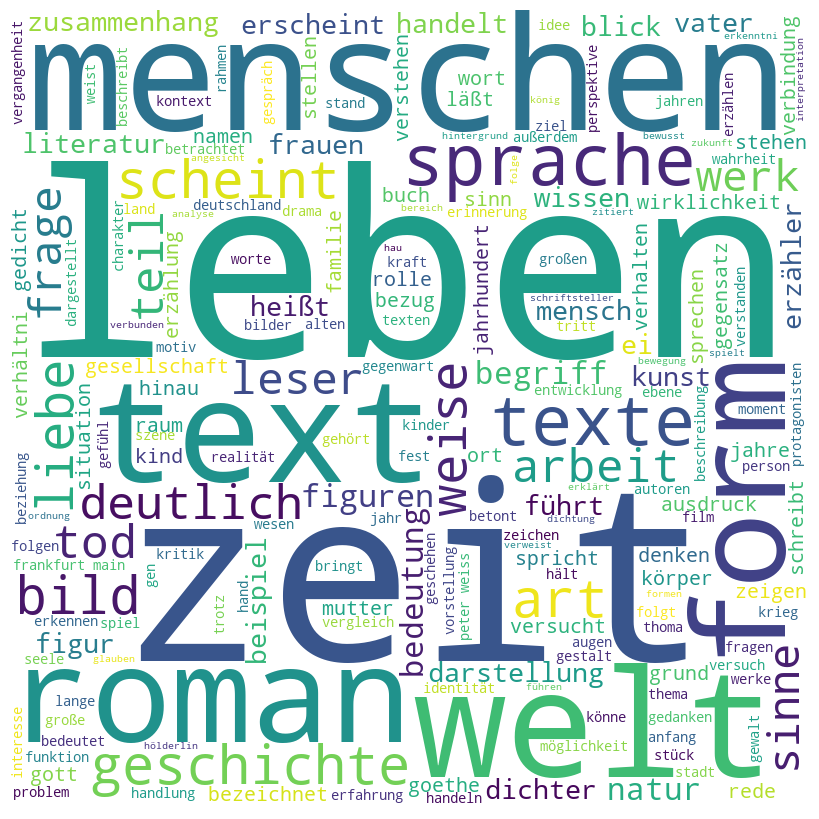

In [68]:
# Quellen für die folgenden Codes sind oben unter den Links zu finden
# Hier eine WordCloud mit 200 Begriffen

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_tokens) # max_words ist standardmäßig auf 200, wird hier also so belassen
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud.to_file("wordcloud_200.png") # Speichern in Datei

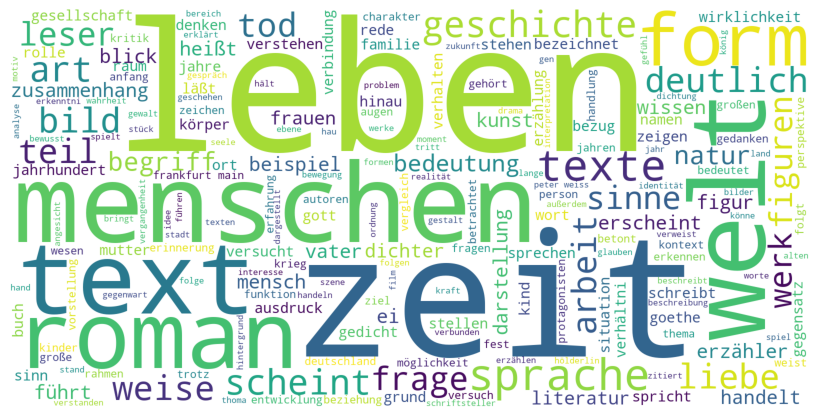

In [73]:
# Quellen für die folgenden Codes sind oben unter den Links zu finden
# Hier eine breitere WordCloud mit 200 Begriffen

wordcloud_big = WordCloud(width = 1600, height = 800,
                background_color ='white',
                min_font_size = 10).generate(all_tokens) # max_words ist standardmäßig auf 200, wird hier also so belassen
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_big)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud_big.to_file("wordcloud_big.png") # Speichern in Datei

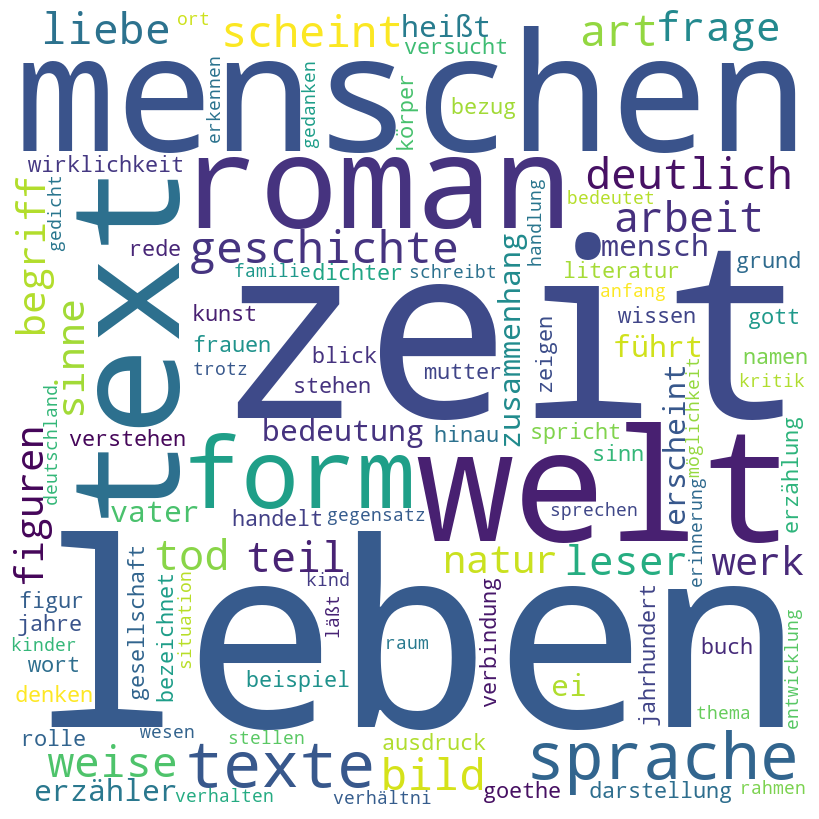

In [64]:
# Hier eine Wordcloud mit 100 Begriffen

wordcloud_100 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words = 100).generate(all_tokens)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_100)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud_100.to_file("wordcloud_100.png")  #Speichern in Datei

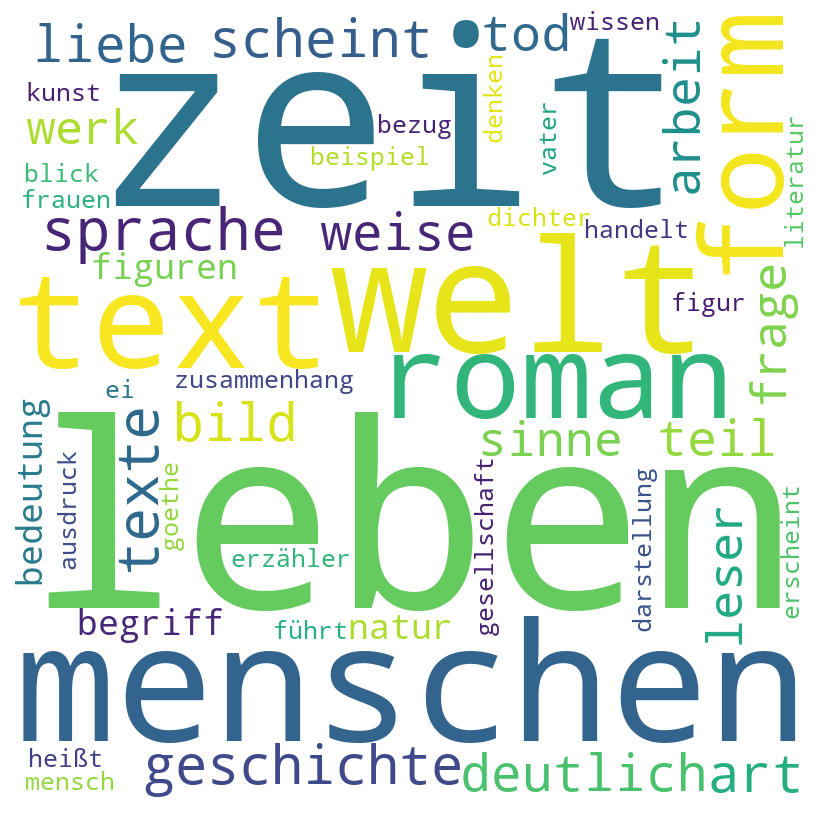

In [69]:
# Hier eine Wordcloud mit 50 Begriffen

wordcloud_50 = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words = 50).generate(all_tokens)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_50)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud_50.to_file("wordcloud_50.png")  #Speichern in Datei

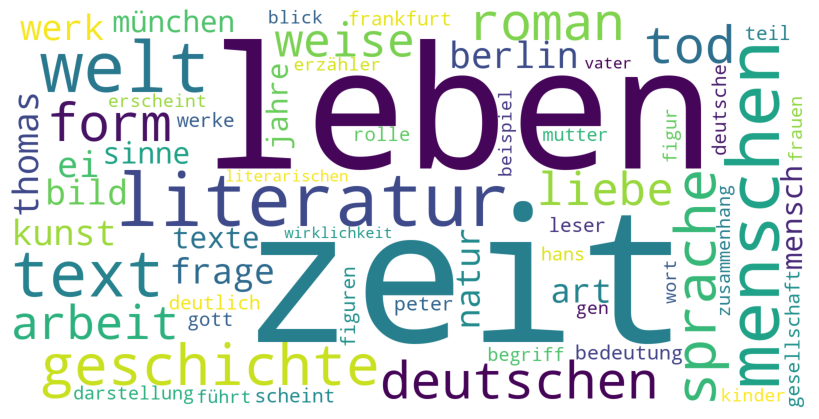

In [82]:
# Hier der Versuch, eine Wordcloud aus den Frequencies zu erstellen
# Da in den Wordclouds davor die Größe des Wortes nicht unbedingt seiner Frequenz entsprach
# Literatur als dritthäufigstes Wort war z.B. viel zu klein dargestellt
# Mit den Counts als Eingabe funktioniert das aber

wordcloud_freq = WordCloud(width = 1600, height = 800,
                background_color ='white',
                min_font_size = 10,
                max_words=60).generate_from_frequencies(counts)
 
# plot the WordCloud image                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud_freq)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

wordcloud_freq.to_file("wordcloud_freq.png")  #Speichern in Datei